In [323]:
import numpy as np
from collections import defaultdict
import os
from os.path import join 
import time
import pandas as pd
import glob
import ntpath

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

In [324]:
def read_data(dataroot,file_ending='*Meter.csv'):
    fields = ['Flow ID','Tot Fwd Pkts','Tot Bwd Pkts','Label']
    
    print(join(dataroot,file_ending))
    filenames = [i for i in glob.glob(join(dataroot,file_ending))]
    
    df_list = []
    for filename in filenames:
        df = pd.read_csv(filename,dtype=object,usecols=fields)        
        df_list.append(df)
    combined_csv = pd.concat(df_list,sort=False)
    combined_csv['flow_length']=(combined_csv['Tot Fwd Pkts'].astype(float)+combined_csv['Tot Bwd Pkts'].astype(float))
    combined_csv.drop(columns=['Tot Fwd Pkts','Tot Bwd Pkts'])
    return combined_csv

In [142]:
gt_dataroot = '/data/juma/data/ids18/CSVs/WS_l'
gt_data = read_data(gt_dataroot)

/data/juma/data/ids18/CSVs/WS_l/*Meter.csv


In [352]:
dataroot = '/data/juma/data/ids18/CSVs_r_1.0/SR_10/FFS_(8,16,4)_l'
data= read_data(dataroot)


/data/juma/data/ids18/CSVs_r_1.0/SR_10/FFS_(8,16,4)_l/*Meter.csv


In [353]:
gdata = data.groupby(['Flow ID','Label'],as_index=False).sum()
print("RPS (#flowRecords vs #flows) ({} vs. {})".format(data.shape[0],gdata.shape[0]))

gt_gdata = gt_data.groupby(['Flow ID','Label'],as_index=False).sum()
print("GT #flowRecords vs #flows {} vs. {}",gt_data.shape[0],gt_gdata.shape[0])


RPS (#flowRecords vs #flows) (1496584 vs. 425913)
GT #flowRecords vs #flows {} vs. {} 8296436 776303


In [354]:
print('GT flows              : {:7}'.format(gt_gdata.shape[0]))
print('Flow Observation Rate : {:.2f}'.format(gdata.shape[0]/gt_gdata.shape[0]*100))
print()
print("Absolute error: {:10}".format(gt_gdata.shape[0]-gdata.shape[0]))
print("Relative error: {:8.2f}".format((gt_gdata.shape[0]-gdata.shape[0])/gdata.shape[0]))

GT flows              :  776303
Flow Observation Rate : 54.86

Absolute error:     350390
Relative error:     0.82


In [355]:
gdata = gdata.rename(columns={'flow_length':'flow_length_est'})

In [356]:
gt_gdata = gt_gdata.set_index(['Flow ID','Label'])
gdata = gdata.set_index(['Flow ID','Label'])


In [357]:
res = gt_gdata.join(gdata)

In [358]:
res = res.fillna(0)
res.columns

Index(['flow_length', 'flow_length_est'], dtype='object')

In [359]:
res = res.sort_values(['flow_length'])
res.head()

,,flow_length,flow_length_est
Flow ID,Label,,
172.31.69.13-172.31.69.8-34661-25734-6,Benign,1.0,0.0
172.31.69.24-172.31.69.11-33867-2002-6,Benign,1.0,0.0
172.31.69.24-172.31.69.11-33867-2001-6,Benign,1.0,0.0
172.31.69.24-172.31.69.11-33867-20005-6,Benign,1.0,0.0
172.31.69.24-172.31.69.11-33867-20000-6,Benign,1.0,1.0


plot for  FFS_(8,16,4)_l


/data/juma/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


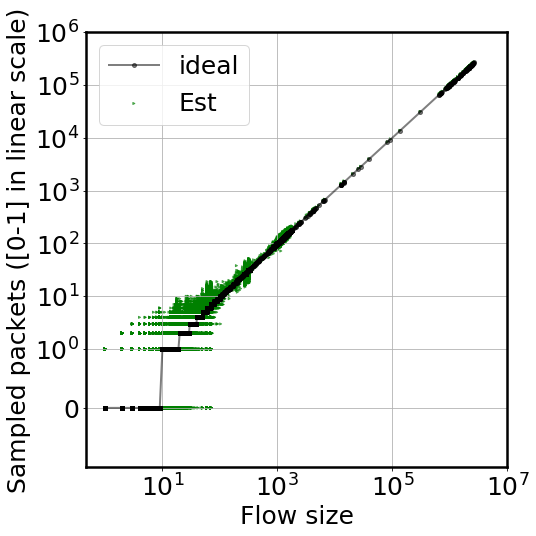

In [360]:
#drawing
print('plot for ',ntpath.basename(dataroot))
font = {'size'   : 25}
plt.rc('font', **font)
plt.rcParams["axes.linewidth"]  = 2.5
fig, ax = plt.subplots(nrows=1,ncols=1,sharex=False,figsize=(8,8))
plt.grid()
plt.scatter(res['flow_length'].values,res['flow_length_est'],alpha=0.75, s=4, label='Est',marker='>',color='g',facecolors='none')
#plt.scatter(res['flow_length'].values,res['flow_length'].values//10,alpha=0.25,color='black',
#            label='ideal',facecolors='none',marker='d')
plt.plot(res['flow_length'].values,res['flow_length'].values//10,alpha=0.5,color='black',
            label='ideal',linewidth=2,marker='o',markeredgewidth=1,markersize=4)
plt.yscale('symlog',linthreshy=1)
plt.xscale('log')
plt.ylabel('Sampled packets ([0-1] in linear scale)')
plt.legend()
plt.ylim([-10**0,10**6])
plt.xlim([-10**0,10**7])
plt.xlabel('Flow size')
fig.tight_layout()
plt.savefig(join(dataroot,'sampled_packet_per_flow.png'))

In [361]:
plt.show()